In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import re
import gzip

import matplotlib

font = {'family' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
matplotlib.rc('text',  usetex=True)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
TS_START=2000
TS_END=2200
NUM_SAMPLES=float(1<<10)
NOISE_FLOOR=-92
INDEX="time"

CCA=-90
CCA_OVERRIDE={}

In [3]:
from enum import Enum
    
class Chanspec:
    WL_CHANSPEC_CHAN_MASK=0x00ff

    WL_CHANSPEC_BW_MASK=0x3800
    class Bandwidth(Enum):
        WL_CHANSPEC_BW_5=0x0000
        WL_CHANSPEC_BW_10=0x0800
        WL_CHANSPEC_BW_20=0x1000
        WL_CHANSPEC_BW_40=0x1800
        WL_CHANSPEC_BW_80=0x2000
        WL_CHANSPEC_BW_160=0x2800
        WL_CHANSPEC_BW_8080=0x3000
    
    WL_CHANSPEC_BAND_MASK=0xc000
    class Band(Enum):
        WL_CHANSPEC_BAND_2G=0x0000
        WL_CHANSPEC_BAND_3G=0x4000
        WL_CHANSPEC_BAND_4G=0x8000
        WL_CHANSPEC_BAND_5G=0xc000
        
    def __init__(self,chanspec):
        self.channel=chanspec&self.WL_CHANSPEC_CHAN_MASK
        self.bandwidth=self.Bandwidth(chanspec&self.WL_CHANSPEC_BW_MASK)
        self.band=self.Band(chanspec&self.WL_CHANSPEC_BAND_MASK)
        
    def __repr__(self):
        return "Channel: %d, Bandwidth %s, Band %s"%(self.channel,self.bandwidth.name,self.band.name)

WL_CHANSPEC_BAND_SHIFT=14

In [4]:
dfs={}
load={}

load["pi1"]="rpi93/rssi-1590126172.csv.gz"
load["pi2"]="rpi91/rssi-1590126176.csv.gz"
load["pi3"]="rpi92/rssi-1590126172.csv.gz"
load["pi4"]="rpi94/rssi-1590126170.csv.gz"
load["pi5"]="rpi90/rssi-1590126176.csv.gz"

for key in load.keys():
    with gzip.GzipFile(load[key]) as decompressedFile:
        print("%s: %s"%(key,load[key]))
        dfs[key]=pd.read_csv(decompressedFile,parse_dates=["time"],index_col=0)
        chanspec=Chanspec(dfs[key].iloc[0].chanspec)
        print("%s: %s"%(key,chanspec))  

pi1: rpi93/rssi-1590126172.csv.gz


/home/schuschu/jupyter/venv3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


pi1: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G
pi2: rpi91/rssi-1590126176.csv.gz
pi2: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G
pi3: rpi92/rssi-1590126172.csv.gz
pi3: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G
pi4: rpi94/rssi-1590126170.csv.gz
pi4: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G
pi5: rpi90/rssi-1590126176.csv.gz
pi5: Channel: 7, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G


In [5]:
nfs={}
for key in dfs.keys():
    df=dfs[key]
    nfs[key]=df.copy()
    nfs[key]["power"]=(df["power"]/NUM_SAMPLES)+NOISE_FLOOR

In [6]:
offset_time=None

zfs={}
mfs={}
for key in nfs.keys():
    zfs[key]=nfs[key].copy(deep=True)
    if offset_time==None:
        offset_time=zfs[key]["time"].iloc[0]
    zfs[key]["time"]-=offset_time
    zfs[key]["tsf"]-=zfs[key]["tsf"].iloc[0]
    zfs[key]["time"]=zfs[key]["time"].dt.total_seconds()*1e3
    zfs[key]["tsf"]=zfs[key]["tsf"]/1e3
    zfs[key]=zfs[key].set_index(INDEX,drop=True)
    zfs[key]=zfs[key][TS_START:TS_END]

    mfs[key]=zfs[key].copy(deep=True)
    MAX_VAL=zfs[key]["power"].max()
    MIN_VAL=zfs[key]["power"].min()
    
    pf=mfs[key].power.copy(deep=True)
    if key in CCA_OVERRIDE:
        TCCA=CCA_OVERRIDE[key]
    else:
        TCCA=CCA
    pf[pf > TCCA]=MAX_VAL
    pf[pf <= TCCA]=MIN_VAL
    mfs[key]["power"]=pf

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


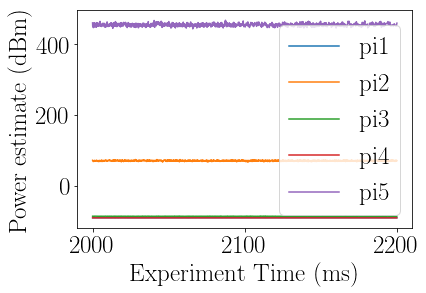

In [7]:
ax=None

for key in zfs.keys():
    if ax==None:
        ax=zfs[key]["power"].plot()
    else:
        ax=zfs[key]["power"].plot(ax=ax,figsize=(6,4),title="")

ax.legend(mfs.keys());
ax.set_ylabel("Power estimate (dBm)");
ax.set_xlabel("Experiment Time (ms)");